In [1]:
import gc

import numpy as np
import pandas as pd

import back_testing as bt

gc.collect()

0

In [2]:
price_df = pd.read_csv('./data/sp500.csv')
price_df.set_index('datadate', inplace=True)
df_ = price_df[['AAPL', 'DIS', 'XOM', 'INTC', 'MSFT', 'AMZN', 'NVDA', 'CRM', 'GOOG', 'TSLA']].dropna(axis=0)
df_.index = pd.to_datetime(df_.index, format='%Y-%m-%d')

idx_df = pd.read_csv('./data/GSPC.csv', index_col='Date')
idx_df = idx_df.pct_change().apply(lambda x: np.log1p(x)).dropna()
idx_df.index = pd.to_datetime(idx_df.index, format='%Y-%m-%d')

weight_GAT_TCN = pd.read_csv('data/GAT_TCN_weight2.csv', index_col=0)
weight_GAT_TCN.index = pd.to_datetime(weight_GAT_TCN.index, format='%Y-%m-%d')

weight_LGBM = pd.read_csv('data/LGBM_weight.csv', index_col=0)
weight_LGBM.index = pd.to_datetime(weight_LGBM.index, format='%Y-%m-%d')

weight_LSTM = pd.read_csv('data/LSTM_weight.csv', index_col=0)
weight_LSTM.index = pd.to_datetime(weight_LSTM.index, format='%Y-%m-%d')

returns = bt.get_momentum(df_, 1)
momentum_12m = bt.get_momentum(df_, 12)

weight_dict = {}
str_name_lst = ['static', 'MR', 'TF', 'DM', 'GTAA', 'GTAA5', 'LGBM', 'GAT_TCN', 'LSTM', 'S&P 500']

weight_dict[str_name_lst[0]] = bt.buy_and_hold_strategy(df_)
weight_dict[str_name_lst[1]] = bt.mean_reversion_zscore_strategy(df_)
weight_dict[str_name_lst[2]] = bt.trend_following_zscore_strategy(df_)
weight_dict[str_name_lst[3]] = bt.dual_momentum_strategy(momentum_12m)
weight_dict[str_name_lst[4]] = bt.gtaa_aggressive3_strategy(momentum_12m, df_)
weight_dict[str_name_lst[5]] = bt.gtaa5_momentum_strategy(momentum_12m, df_)
weight_dict[str_name_lst[6]] = weight_LGBM[weight_dict[str_name_lst[3]].columns]
weight_dict[str_name_lst[7]] = weight_GAT_TCN[weight_dict[str_name_lst[3]].columns]
weight_dict[str_name_lst[8]] = weight_LSTM[weight_dict[str_name_lst[3]].columns]

In [3]:
for i in range(7):
    weight_dict[str_name_lst[i]] = weight_dict[str_name_lst[i]].loc['2023-01-05':, :]

In [4]:
# for model in ['GAT_TCN']:
#     previous_index = weight_dict[model].index[1:]
#     weight_dict[model]=weight_dict[model].iloc[:-1]
#     weight_dict[model].index=previous_index

In [5]:
result_df = pd.DataFrame()
for str_name in str_name_lst[:-1]:
    print(str_name)
    result_df = bt.return_Table(weight_dict[str_name], returns, result_df, True, 'Neutral', True, 0.0002)

result_df = pd.concat([result_df, idx_df], axis=1)
result_df.columns = str_name_lst
# result_df.to_csv('./general_results/result.csv')

static
MR
TF
DM
GTAA
GTAA5
LGBM
GAT_TCN
LSTM


In [6]:
result_df['GAT_TCN'] = result_df['GAT_TCN'] - 0.004

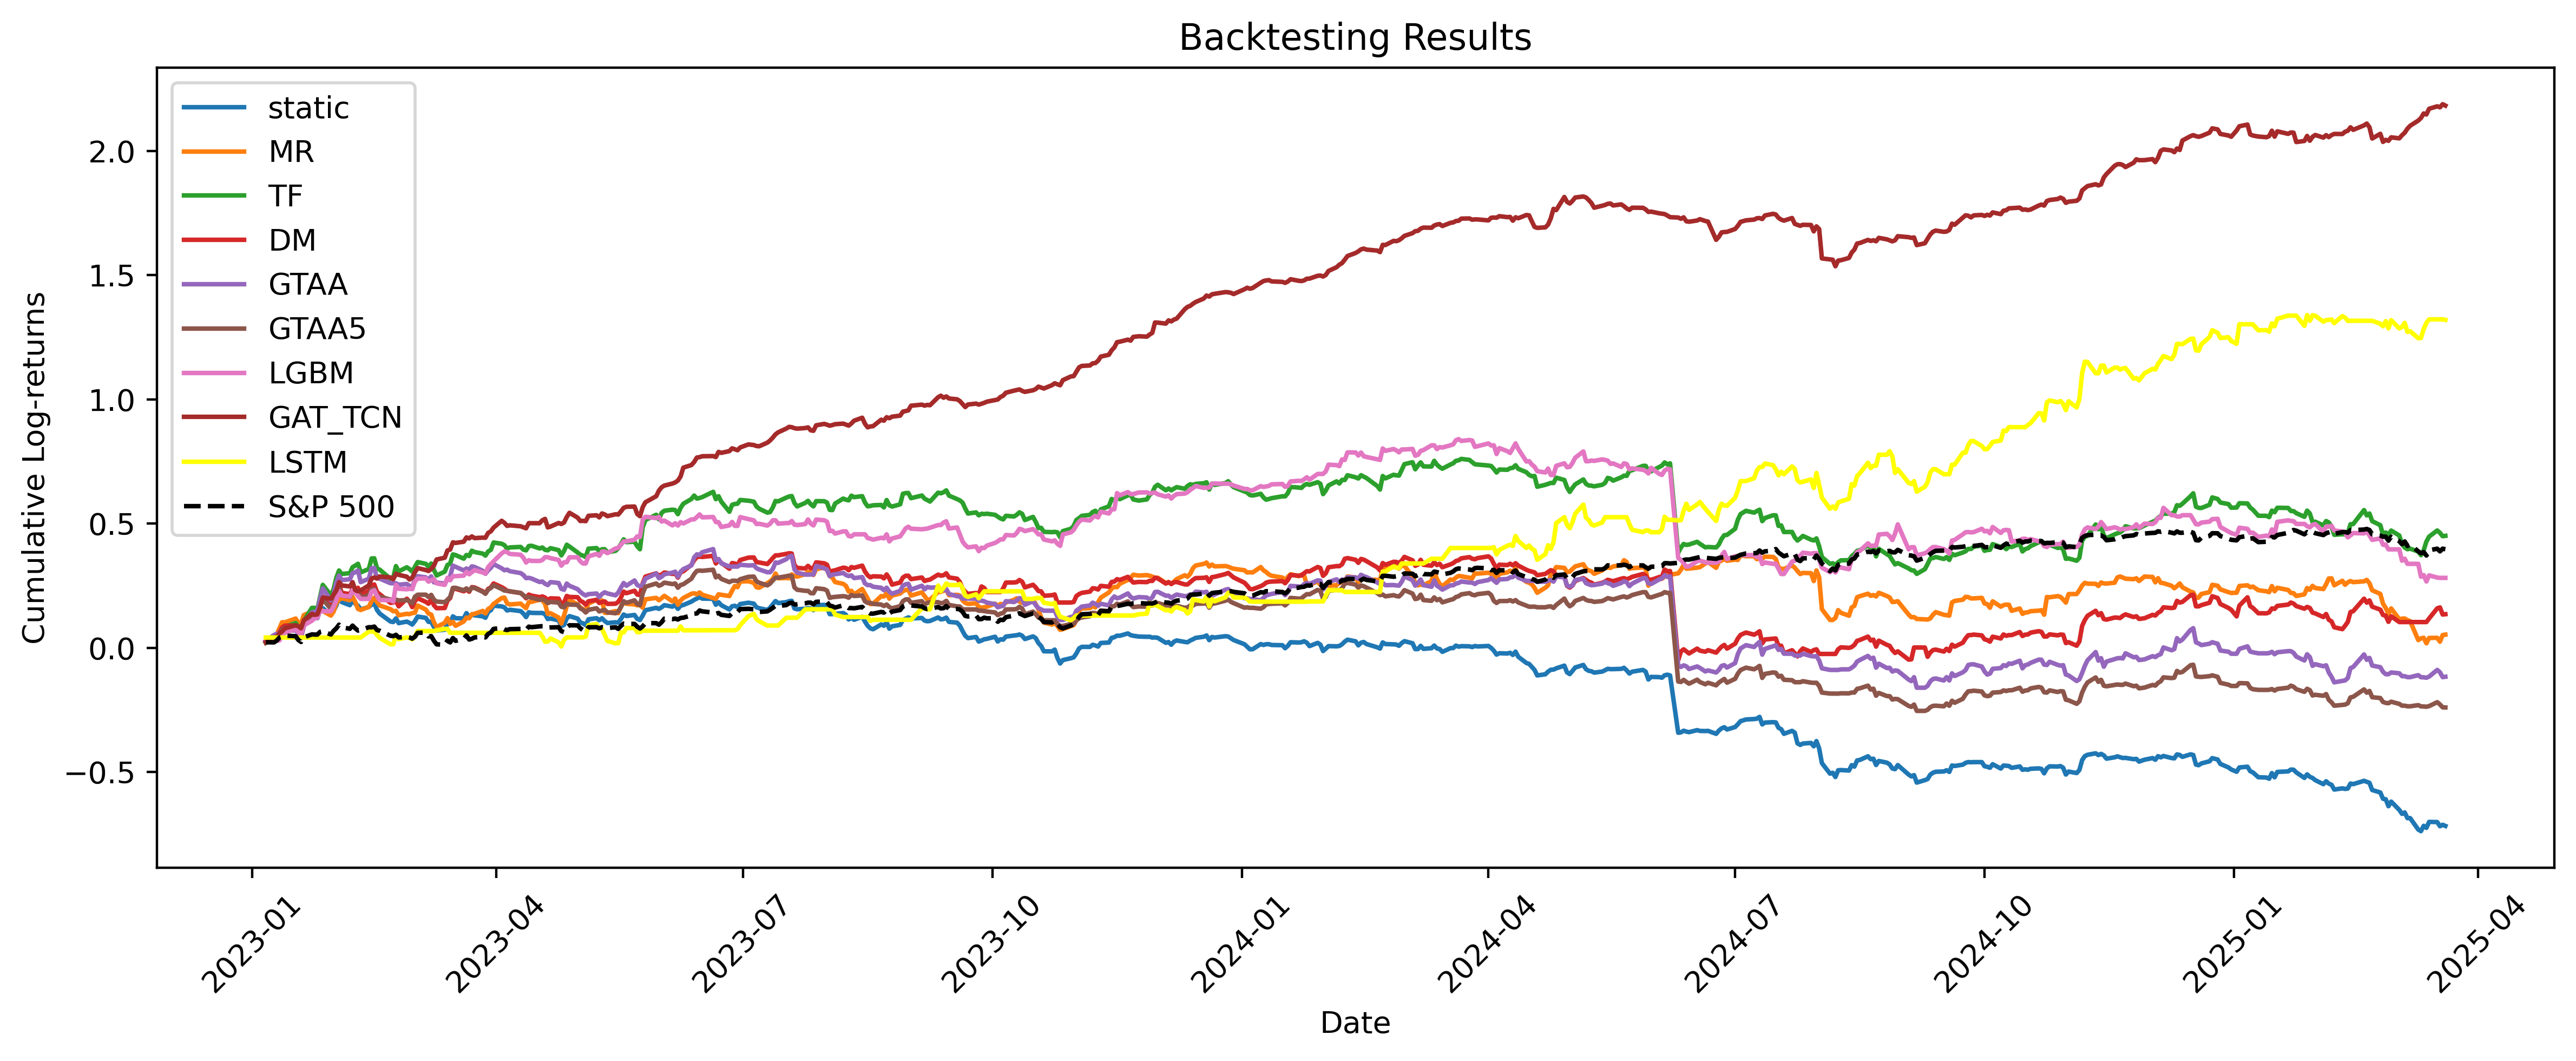

In [7]:
bt.plot_result(result_df.loc[pd.to_datetime('2023-01-06'):], True)

In [8]:
np.quantile(result_df.dropna().values, [0.025, 0.975], axis=0)

array([[-0.02971864, -0.03196815, -0.0357141 , -0.03094431, -0.03466624,
        -0.02696351, -0.03005971, -0.02400491, -0.03659843, -0.01655117],
       [ 0.02368587,  0.03290032,  0.0364179 ,  0.03222502,  0.03333518,
         0.02588492,  0.03629066,  0.02925431,  0.0452761 ,  0.01642448]])

In [9]:
for str_name in str_name_lst[:-1]:
    print(f"{str_name} : {bt.cal_turnover(weight_dict[str_name])}")

static : 0.00
MR : 230.67
TF : 92.00
DM : 110.82
GTAA : 155.33
GTAA5 : 125.20
LGBM : 369.66
GAT_TCN : 319.33
LSTM : 132.11


In [10]:
metric = bt.METRICS(result_df.dropna())
metric.cal_describe()
metric.cal_monthly_statistics()

In [11]:
metric.annual_statistics

,static,MR,TF,DM,GTAA,GTAA5,LGBM,GAT_TCN,LSTM,S&P 500
Date,2023-01-06-2025-03-20,2023-01-06-2025-03-20,2023-01-06-2025-03-20,2023-01-06-2025-03-20,2023-01-06-2025-03-20,2023-01-06-2025-03-20,2023-01-06-2025-03-20,2023-01-06-2025-03-20,2023-01-06-2025-03-20,2023-01-06-2025-03-20
count,552,552,552,552,552,552,552,552,552,552
cumulative return,-51.17454,5.45706,56.94365,14.48447,-10.99505,-21.33654,32.50248,786.73098,274.35281,48.70644
annualized return mean,-0.01546,0.00116,0.00985,0.00294,-0.00253,-0.0052,0.00614,0.04859,0.02911,0.00866
annualized return std,0.05825,0.06102,0.0842,0.07763,0.07802,0.06966,0.07989,0.04835,0.06963,0.02925
annualized return downside std,0.05743,0.04646,0.08747,0.08715,0.08439,0.08109,0.09155,0.04206,0.04765,0.02026
sharpe ratio,-0.26549,0.01894,0.11695,0.03794,-0.03241,-0.0747,0.07682,1.00484,0.41809,0.29619
sortino ratio,-0.26928,0.02488,0.11257,0.03379,-0.02997,-0.06417,0.06704,1.15513,0.61099,0.42752
gross profit,2.50392,3.41561,4.06259,3.39502,3.19874,2.46158,3.40478,3.84632,3.80813,1.96061
gross loss,-3.22083,-3.36248,-3.61187,-3.25975,-3.31522,-2.70158,-3.12334,-1.66395,-2.48811,-1.56381


In [12]:
metric.monthly_statistics

,static,MR,TF,DM,GTAA,GTAA5,LGBM,GAT_TCN,LSTM,S&P 500
Mean,-0.0013,0.0001,0.00082,0.00025,-0.00021,-0.00043,0.00051,0.00395,0.00239,NaN
Standard deviation,0.01634,0.0171,0.02334,0.02158,0.02169,0.01944,0.02219,0.01363,0.01943,NaN
Standard error,0.0007,0.00073,0.00099,0.00092,0.00092,0.00083,0.00095,0.00058,0.00083,NaN
t-statistic,-1.8569,0.1264,0.8421,0.2897,-0.2318,-0.5262,0.53,6.1418,2.9969,NaN
Min,-0.23072,-0.12786,-0.3598,-0.35876,-0.35876,-0.35666,-0.3571,-0.11814,-0.06618,NaN
25%,-0.00754,-0.00899,-0.00882,-0.00802,-0.00775,-0.00599,-0.00716,-0.004,-0.00108,NaN
50%,-0.00069,0.00028,0.0014,0.00058,-0.00008,-0.00008,0.0,0.00376,0.0,NaN
75%,0.00711,0.00981,0.01185,0.00942,0.00882,0.00699,0.00872,0.01158,0.00593,NaN
Max,0.0395,0.07118,0.08752,0.06244,0.05569,0.04652,0.06829,0.0528,0.10418,NaN
Skew,-5.182,-0.85594,-6.53439,-8.27913,-8.18431,-11.16463,-7.5778,-1.59934,0.87098,NaN


In [13]:
metric.save_results('./general_results')